# Road Marking Detection and Classification using U-Net Architecture

Author: Dhruv Hingu  
Affiliation: Student at Ahmedabad University  

---

This notebook implements road marking detection and classification using a segmentation approach with the U-Net architecture. The code presented here is developed by Dhruv Hingu for the purpose of road marking analysis.



In [11]:
import numpy as np
import pandas as pd 
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable
from PIL import Image
import io
import seaborn as sns
sns.set_style('dark')
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16

## Defining A few Functions for plotting

In [12]:
@register_keras_serializable
def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
    
    return iou

In [13]:
def mask_to_color_image(predicted_mask, class_colors):
    color_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_label, color in enumerate(class_colors):
        color_mask[predicted_mask == class_label] = color

    return color_mask

In [14]:
def resize_image(image, target_size):
    resized_image = cv2.resize(image, target_size[::-1], interpolation=cv2.INTER_NEAREST)
    return resized_image


In [15]:
class_colors = [
    (0, 0, 0),# black Background
    (255, 0, 0), # red traffic sign
    (0, 255, 0), # green Divider
    (0, 0, 255), # blue lane marking
    (255, 255, 255),# white Zebra- crossing
]


In [16]:
def resize_image_pillow(image_path, target_size=(256, 256), quality=100):
    # Open the image using Pillow
    image = Image.open(image_path)

    # Resize the image while preserving aspect ratio
    image.thumbnail(target_size, Image.ANTIALIAS)

    # Convert the image to RGB (if not already in RGB mode)
    image = image.convert('RGB')

    # Save the resized image to a BytesIO object to control JPEG quality
    output = io.BytesIO()
    image.save(output, format='JPEG', quality=quality)

    # Read the resized image back from the BytesIO object
    resized_image = Image.open(output)
    resized_image = np.array(resized_image)  # Convert PIL Image to NumPy array

    return resized_image

In [17]:
def find_pixel_length_width_color(mask_image, original_image):
    gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    dimensions = []
    contour_colors = []
    contour_labels = []

    reference_colors = {
        "Lane marking": (0, 0, 255),
        "Lane Edge": (0, 255, 0),
        "Zebra Crossing": (255, 255, 255),
        "Traffic sign": (255, 0, 0)
    }

    for contour in contours:
        # Minimum area rectangle
        area = cv2.contourArea(contour)

        # Check if contour area is above the minimum threshold
        # (if area of contour is less than 150 don't consider it)
        if area < 150:
            continue 
        
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)  
        box = np.int0(box)  

        # Calculate dimensions
        width = np.linalg.norm(box[0] - box[1])
        height = np.linalg.norm(box[1] - box[2])
        dimensions.append((width, height))

        
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        mean_color = cv2.mean(mask_image, mask=mask)[:3]
        contour_colors.append(mean_color)

        
        min_distance = float('inf')
        assigned_label = "Unknown" # This is for marking which doesn't get identified

        for label, color in reference_colors.items():
            distance = np.linalg.norm(np.array(mean_color) - np.array(color))
            if distance < min_distance:
                min_distance = distance
                assigned_label = label

        contour_labels.append(assigned_label)

        cv2.drawContours(original_image, [box], 0, (0, 0, 255), 2)

        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)

        # Place text label inside the bounding box
        cv2.putText(original_image, f"{len(contour_labels)}) {assigned_label}", (x + int(w * 0.05), y + int(h * 0.5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # Plot the image with bounding boxes and labels
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Marking Detection and Classification')
    plt.axis('off')
    plt.show()

    return dimensions, contour_colors, contour_labels

## Loading the model which I trained 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/tmp/ipykernel_33/1932253897.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


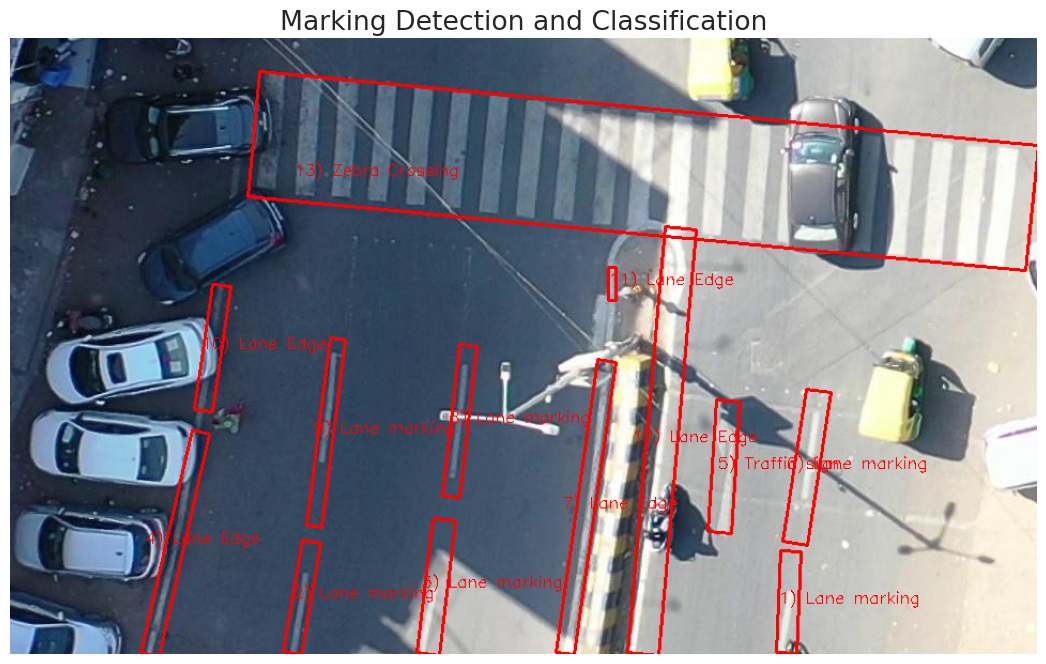

Mark 1:'Lane marking'  Width = 95.08px, Height = 19.03px,
Mark 2:'Lane marking'  Width = 105.55px, Height = 17.26px,
Mark 3:'Lane marking'  Width = 125.90px, Height = 21.10px,
Mark 4:'Lane Edge'  Width = 213.47px, Height = 16.49px,
Mark 5:'Traffic sign'  Width = 123.26px, Height = 22.09px,
Mark 6:'Lane marking'  Width = 143.69px, Height = 23.19px,
Mark 7:'Lane Edge'  Width = 276.76px, Height = 17.26px,
Mark 8:'Lane marking'  Width = 142.90px, Height = 16.12px,
Mark 9:'Lane marking'  Width = 176.38px, Height = 14.14px,
Mark 10:'Lane Edge'  Width = 118.23px, Height = 17.12px,
Mark 11:'Lane Edge'  Width = 7.00px, Height = 31.00px,
Mark 12:'Lane Edge'  Width = 399.54px, Height = 29.15px,
Mark 13:'Zebra Crossing'  Width = 117.52px, Height = 731.26px,


In [19]:
image_path = '/kaggle/input/marking-test/v_4_30.jpg'# <-----  # Enter Image Path here

saved_model_path = '/kaggle/working/unet_road_marking.keras'
model = tf.keras.models.load_model(saved_model_path, custom_objects={'iou_coef': iou_coef})

original_image = cv2.imread(image_path)
# Operations on original Image (to make in compatible to model input)
image_size = (original_image.shape[0], original_image.shape[1])
resized_image = cv2.resize(original_image, (256, 256))
input_image = resized_image.astype(np.float32) / 255.0
input_image = np.expand_dims(input_image, axis=0)


# Model Predicts
predicted_masks = model.predict(input_image) 

# Operation on predicted mask for proper visualization
predicted_labels = np.argmax(predicted_masks[0], axis=-1)
color_mask = mask_to_color_image(predicted_labels, class_colors)
target_size = image_size
resized_mask = resize_image(color_mask, target_size)
mask_image = resized_mask

dimensions, contour_colors, contour_labels = find_pixel_length_width_color(mask_image, original_image)

# This will display details about each markings
for i, ((width, height), color, label) in enumerate(zip(dimensions, contour_colors, contour_labels), start=1):
    print(f"Mark {i}:'{label}'  Width = {width:.2f}px, Height = {height:.2f}px,")
